In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from fna.tools.signals import make_simple_kernel, pad_array

import os
import sys
import re
import sys

import pickle


plt.rcParams.update({'font.size' : 14})

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [2]:
sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files

In [3]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [4]:
! ls ../../demyelination/data/eaone-recurr-demy-onset/activity/ -l

total 9948
-rw-rw-r-- 1 pbr-student pbr-student 10185145 Jan 20 10:08 'spk_eaone-recurr-demy-onset_gr_scale=1e-05_update_interval=50_0'


In [5]:
exp_name = 'eaone-recurr-demy-onset'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 1

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

** mnist.loader ** package is not installed. To have functions using mnist.loader please install the package.
** tables ** package is not installed. To have functions using tables please install the package.


In [6]:
# gathering spike objects
trn_spkobj = gatherSpikes(pth, fl, nthread, "TRN", 201, 400)
mgn_spkobj = gatherSpikes(pth, fl, nthread, "MGN", 1, 200)
eaone_spkobj = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400)
iaone_spkobj = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900)

In [7]:
# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)

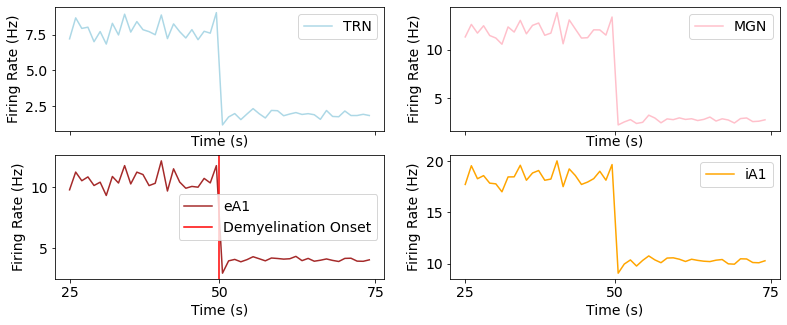

In [8]:
## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(13, 5)

ax = ax.flatten()

tstart = 25 * 1000
tstop = 75 * 1000
    
resolution = 1 * 1000

x = trn_spkobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
# ax[0].axhline(trn_spkobj.time_slice(0, 100 * 1000).mean_rate(), label="Former Mean Firing Rate")
# ax[0].plot(range(0, 100, 10), trn_spkobj.time_slice(tstart, tstop).firing_rate(resolution * 10, average=True))

x = mgn_spkobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
# ax[1].axhline(mgn_spkobj.time_slice(0, 100 * 1000).mean_rate(), label="Former Mean Firing Rate")
# ax[1].plot(range(0, 100, 10), mgn_spkobj.time_slice(tstart, tstop).firing_rate(resolution * 10, average=True))

x = eaone_spkobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
# ax[2].axhline(eaone_spkobj.time_slice(0, 100 * 1000).mean_rate(), label="Mean Firing Rate Before Demy Onset")
# ax[2].plot(range(0, 100, 10), eaone_spkobj.time_slice(tstart, tstop).firing_rate(resolution * 10, average=True))

x = iaone_spkobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
# ax[3].axhline(iaone_spkobj.time_slice(0, 100 * 1000).mean_rate(), label="Former Mean Firing Rate")
# ax[3].plot(range(0, 100, 10), iaone_spkobj.time_slice(tstart, tstop).firing_rate(resolution * 10, average=True))

# x_range = np.arange(0, 123, 1)

# ax[4].plot(x_range, perc_mgn_eA1, ":", label="eA1->eA1")
# ax[4].set_ylabel("Epsilon")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'], label="eA1")
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'], label="MGN")
# ax[5].axhline(.104, ls=":", label="eA1 Target")
# ax[5].axhline(.115, ls=":", label="MGN Target", color="orange")
# ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

ax[2].axvline(24.5, label="Demyelination Onset", color="red")

[ax[_].set_xticks([0, 24.5, 50], [25, 50, 75]) for _ in [2, 3]]

[ax[_].legend() for _ in range(4)];
[ax[_].set_ylabel("Firing Rate (Hz)") for _ in range(4)];
[ax[_].set_xlabel("Time (s)") for _ in range(4)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

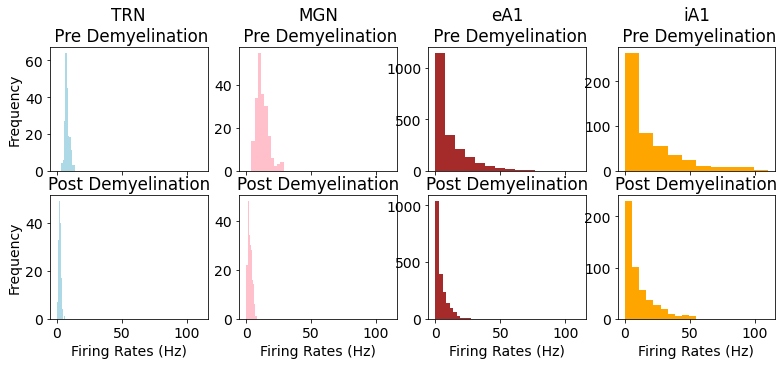

In [10]:

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True)
fig.set_size_inches(13, 5)

den = False

tstart, tstop = 15000, 20000
ax[0][0].hist(trn_spkobj.time_slice(tstart, tstop).mean_rates(), color='lightblue', density=den);
ax[0][1].hist(mgn_spkobj.time_slice(tstart, tstop).mean_rates(), color='pink', density=den);
ax[0][2].hist(eaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='brown', density=den);
ax[0][3].hist(iaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='orange', density=den);


tstart, tstop = 55000, 60000
ax[1][0].hist(trn_spkobj.time_slice(tstart, tstop).mean_rates(), color='lightblue', density=den);
ax[1][1].hist(mgn_spkobj.time_slice(tstart, tstop).mean_rates(), color='pink', density=den);
ax[1][2].hist(eaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='brown', density=den);
ax[1][3].hist(iaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='orange', density=den);

for idx, population in enumerate(["TRN\n", "MGN\n", "eA1\n", "iA1\n"]):
    ax[0][idx].set_title(population + " Pre Demyelination")
    ax[1][idx].set_title("Post Demyelination")

[ax[1][_].set_xlabel("Firing Rates (Hz)") for _ in range(4)];
[ax[_][0].set_ylabel("Frequency") for _ in range(2)];
